In [1]:
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer

from LoopStructural.modelling.fault.fault_function import CubicFunction, FaultDisplacement, Ones, Composite
from LoopStructural.modelling.fault.fault_function_feature import FaultDisplacementFeature

from LoopStructural.datasets import value_headers, strike_dip_headers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
output='eliptical'
if not os.path.exists(output):
    os.mkdir(output)
bb = np.array([[0,0,0],
               [10,10,10]])
fault_value_data = pd.DataFrame([[5,5,9,0,0],
                                 [5,5,5,0,1],
#                                  [7,7,7,1,1],
                                 [5,0,5,0,2],
                                 [5,10,5,1,2],
                                ],
                                columns=value_headers()+['coord'])
fault_value_data['type'] = 'fault'
fault_strike_data = pd.DataFrame([[5,5,5,0,45,0],
                                  [8,5,1,0,0,0],
                                  [5,2,5,0,45,0],
                                  [8,2,1,0,0,0],
                                  [5,7,5,0,45,0],
                                  [8,7,1,0,0,0],
                                  [1,5,8,0,85,0],
                                  [1,2,8,0,85,0],
                                  [1,7,8,0,85,0],
                                  [5,5,5,180,45,1],
                                 [5,5,5,90,90,2]],
                                columns=strike_dip_headers()+['coord'])
fault_strike_data['type'] = 'fault'
strati_data = pd.DataFrame([[5,5,5,0]],columns=value_headers())
strati_data['type'] = 'strati'
strati_strike = pd.DataFrame([[5,5,5,0,0]],columns=strike_dip_headers())
strati_strike['type'] = 'strati'

In [3]:
data = pd.concat([fault_strike_data,fault_value_data,strati_strike,strati_data],sort=False)

In [4]:
rotation = [76.60582733154297, -13.266486167907715, -176.5645294189453]

### Set up the model

In [5]:
import logging
logging.getLogger().setLevel(logging.INFO)

In [6]:
model = GeologicalModel(bb[0,:],bb[1,:])
model.set_model_data(data)

hw = CubicFunction()
hw.add_cstr(0,1)
hw.add_grad(0,0)
hw.add_cstr(1,0)
# hw.add_cstr(1,1)

hw.add_grad(1,0)
hw.add_max(1)
fw =CubicFunction()
fw.add_cstr(0,-1)
fw.add_grad(0,0)
fw.add_cstr(-1,0)
fw.add_grad(-1,0)
fw.add_min(-1)
gyf = CubicFunction()
gyf.add_cstr(-1,0)
gyf.add_cstr(1,0)
gyf.add_cstr(-0.2,1)
gyf.add_cstr(0.2,1)
gyf.add_grad(0,0)
gyf.add_min(-1)
gyf.add_max(1)
gzf = CubicFunction()
gzf.add_cstr(-1,0)
gzf.add_cstr(1,0)
gzf.add_cstr(-0.2,1)
gzf.add_cstr(0.2,1)
gzf.add_grad(0,0)
gzf.add_min(-1)
gzf.add_max(1)
gxf = Composite(hw,fw)


fault_displacement = FaultDisplacement(gx=gxf,gy=gyf,gz=gzf,
                                      gxmin=-2,gxmax=2,
                                      gzmin=.5,gzmax=1.2,
                                       gymin=0,gymax=1.5)

fault = model.create_and_add_fault('fault',
                                   1,
                                   regularisation = [0.1,5,5],
                                   nelements=5000,
                                   interpolatortype='FDI',
                                   solver='lu',
                                   damp=True,
                                   faultfunction=fault_displacement,buffer=0.2)
strati = model.create_and_add_foliation('strati',
                                        nelements=5000,
                                        interpolatortype='FDI',
                                        solver='lu',
                                        damp=True,buffer=0.5)
f1_displacement_feature = FaultDisplacementFeature(fault['feature'].faultframe,fault_displacement)


INFO:LoopStructural.modelling.features.structural_frame_builder:Building fault coordinate 2
INFO:LoopStructural.modelling.features.geological_feature_builder:Adding 0 faults to fault_2
INFO:LoopStructural.interpolators.discete_interpolator:Interpolation matrix is 35313 x 6859
INFO:LoopStructural.interpolators.discete_interpolator:Adding eps to matrix diagonal
INFO:LoopStructural.interpolators.discete_interpolator:Solving using scipy LU
INFO:LoopStructural.modelling.features.structural_frame_builder:Building fault coordinate 1
INFO:LoopStructural.modelling.features.geological_feature_builder:Adding 0 faults to fault_1
INFO:LoopStructural.interpolators.discete_interpolator:Interpolation matrix is 41146 x 6859
INFO:LoopStructural.interpolators.discete_interpolator:Adding eps to matrix diagonal
INFO:LoopStructural.interpolators.discete_interpolator:Solving using scipy LU
INFO:LoopStructural.modelling.features.geological_feature_builder:Adding 1 faults to strati
INFO:LoopStructural.modellin

INFO:LoopStructural.visualisation.model_visualisation:Creating isosurface of fault_0 at -4.763625



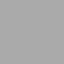

In [7]:
viewer =  LavaVuModelViewer(model)
viewer.add_data(fault['feature'][0])
viewer.add_isosurface(fault['feature'][0])
viewer.interactive()

### Fault displacement figure

In [8]:
fregion = lambda pos : f1_displacement_feature.evaluate_value(pos) > 0.01


INFO:LoopStructural.visualisation.model_visualisation:Adding scalar field of fault_displacement to viewer. Min: 0.000000, max: 1.000000



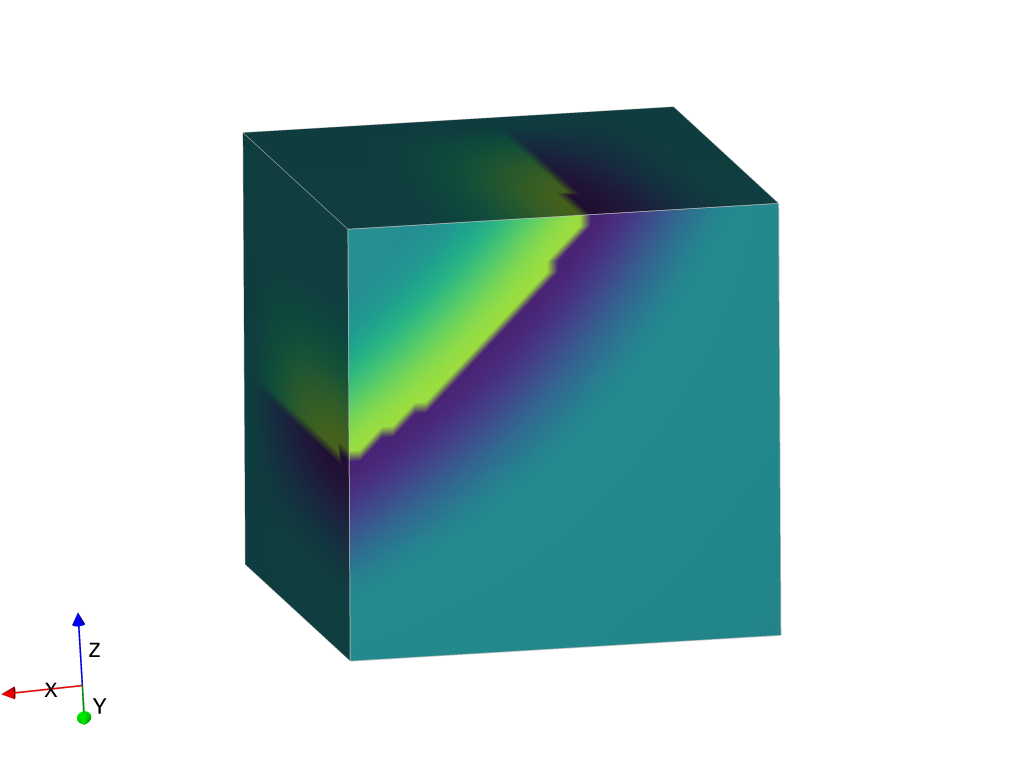

'eliptical/fault_displacement.png'

In [9]:
viewer = LavaVuModelViewer(model)

# f1_displacement_feature = FaultDisplacementFeature(fault['feature'].faultframe,fault_displacement)
viewer.add_scalar_field(f1_displacement_feature,cmap='viridis',vmin=-1,xmax=1)
# viewer.lv.rotatey(90)
viewer.lv.rotate(rotation)
viewer.lv.display()
viewer.lv.image(output+'/fault_displacement.png')

### Faulted stratigraphy figure

INFO:LoopStructural.visualisation.model_visualisation:Creating isosurface of fault at 0.000000
INFO:LoopStructural.visualisation.model_visualisation:Creating isosurface of strati at -10.349827
INFO:LoopStructural.visualisation.model_visualisation:Creating isosurface of strati at -5.624832
INFO:LoopStructural.visualisation.model_visualisation:Creating isosurface of strati at -0.899838
INFO:LoopStructural.visualisation.model_visualisation:Creating isosurface of strati at 3.825156
INFO:LoopStructural.visualisation.model_visualisation:Creating isosurface of strati at 8.550150
INFO:LoopStructural.visualisation.model_visualisation:Adding scalar field of strati to viewer. Min: -11.399825, max: 9.600148



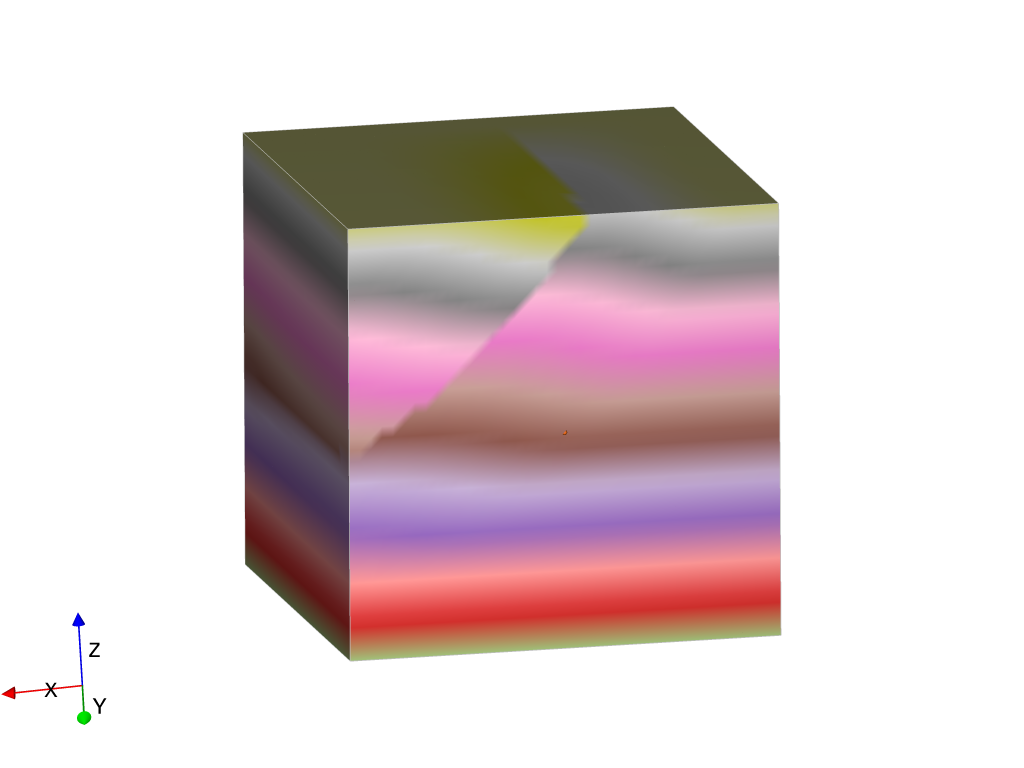

'eliptical/stratigraphy.png'

In [10]:
viewer = LavaVuModelViewer(model)
viewer.add_isosurface(fault['feature'],isovalue=0)
for i in range(3):
    viewer.add_data(fault['feature'][i])
# viewer.add_isosurface(fault['feature'][1],nslices=5)
# # viewer.add_isosurface(fault['feature'][2],nslices=5)
viewer.add_isosurface(strati['feature'],
                     nslices=5)
viewer.add_scalar_field(strati['feature'],cmap='tab20')
# viewer.add_scalar_field(f1_displacement_feature,cmap='rainbow')
viewer.lv.rotate(rotation)
viewer.lv.display()
viewer.lv.image(output+'/stratigraphy.png')
# viewer.interactive()

### Surfaces

INFO:LoopStructural.visualisation.model_visualisation:Adding y section at 0.000000
INFO:LoopStructural.visualisation.model_visualisation:Creating isosurface of strati at 4.000000
INFO:LoopStructural.visualisation.model_visualisation:Creating isosurface of strati at 3.000000
INFO:LoopStructural.visualisation.model_visualisation:Creating isosurface of strati at 2.000000
INFO:LoopStructural.visualisation.model_visualisation:Creating isosurface of strati at 1.000000



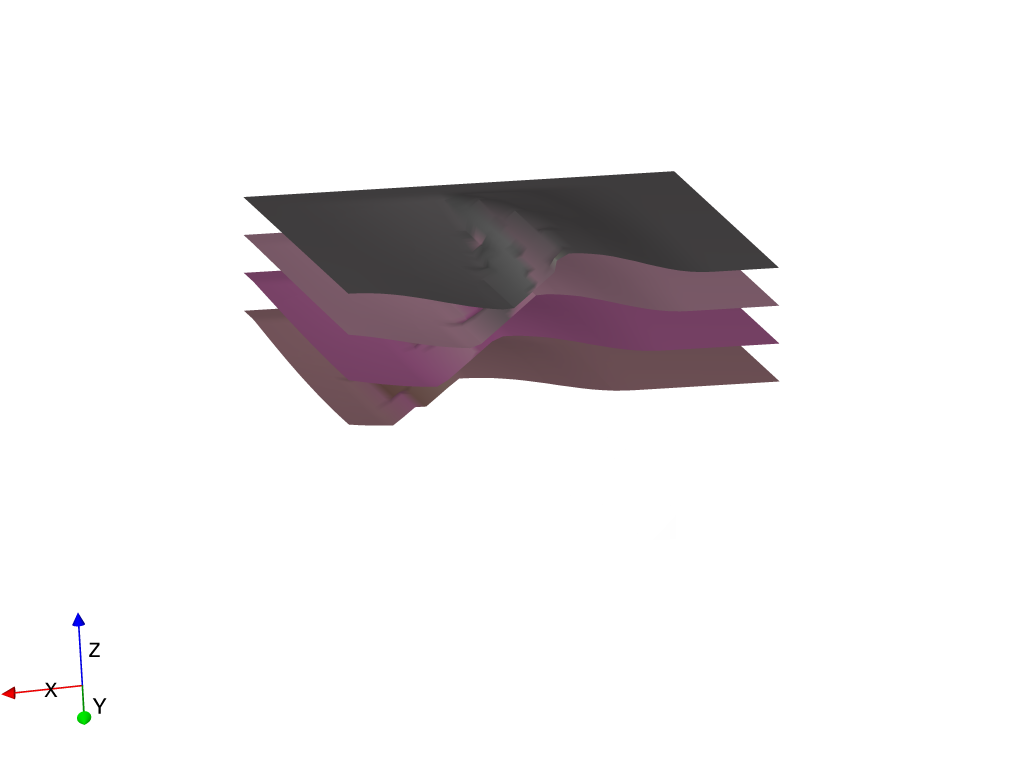

'eliptical/surfaces_nofault.png'

In [11]:
fregion = lambda pos : f1_displacement_feature.evaluate_on_surface(pos) > 0.2
viewer = LavaVuModelViewer(model)
# viewer.nsteps = np.array([100,100,100])
viewer.add_section(None,axis='y',value=model.bounding_box[0,1],colour='white')
# viewer.add_isosurface(fault['feature'][2],
#                       slices=[-.2,.2],
# #                      region=fregion
#                      )
# for i in range(3):
#     viewer.add_data(fault['feature'][i])
# viewer.add_isosurface(fault['feature'][1],nslices=5)
# # viewer.add_isosurface(fault['feature'][2],nslices=5)
viewer.add_isosurface(strati['feature'],
                      slices=[4,3,2,1],
#                      nslices=5,
                     paint_with=strati['feature'],
                      cmap='tab20'
                     )
# viewer.add_scalar_field(strati['feature'],cmap='tab20')
# viewer.add_scalar_field(f1_displacement_feature,cmap='rainbow')
viewer.lv.rotate(rotation)
viewer.lv['border'] = 0

viewer.lv.display()

viewer.lv.image(output+'/surfaces_nofault.png')
# viewer.interactive()

INFO:LoopStructural.visualisation.model_visualisation:Adding y section at 0.000000
INFO:LoopStructural.visualisation.model_visualisation:Creating isosurface of fault at 0.000000
INFO:LoopStructural.visualisation.model_visualisation:Creating isosurface of strati at 4.000000
INFO:LoopStructural.visualisation.model_visualisation:Creating isosurface of strati at 3.000000
INFO:LoopStructural.visualisation.model_visualisation:Creating isosurface of strati at 2.000000
INFO:LoopStructural.visualisation.model_visualisation:Creating isosurface of strati at 1.000000



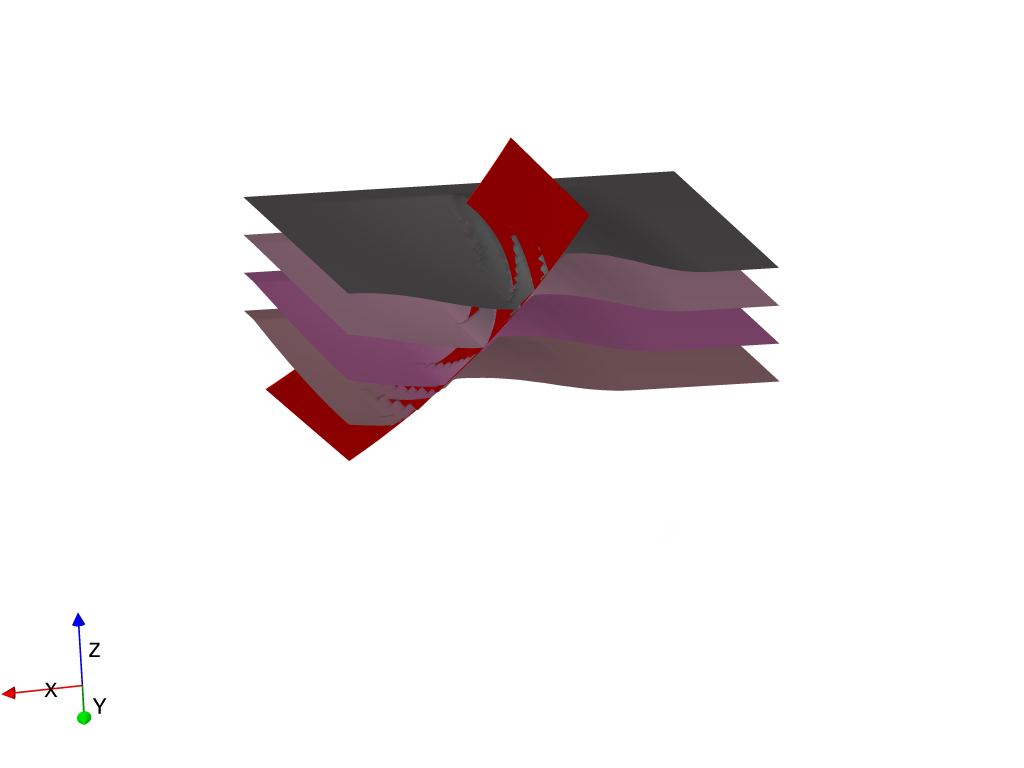

'eliptical/surfaces.png'

In [12]:
fregion = lambda pos : f1_displacement_feature.evaluate_on_surface(pos) > 0.2
viewer = LavaVuModelViewer(model)
viewer.nsteps = np.array([100,100,100])
viewer.add_section(None,axis='y',value=model.bounding_box[0,1],colour='white')
viewer.add_isosurface(fault['feature'],
                      isovalue=0,
                     region=fregion
                     )
# for i in range(3):
#     viewer.add_data(fault['feature'][i])
# viewer.add_isosurface(fault['feature'][1],nslices=5)
# # viewer.add_isosurface(fault['feature'][2],nslices=5)
viewer.add_isosurface(strati['feature'],
                      slices=[4,3,2,1],
#                      nslices=5,
                     paint_with=strati['feature'],
                      cmap='tab20'
                     )
# viewer.add_scalar_field(strati['feature'],cmap='tab20')
# viewer.add_scalar_field(f1_displacement_feature,cmap='rainbow')
viewer.lv.rotate(rotation)
viewer.lv['border'] = 0

viewer.lv.display()

viewer.lv.image(output+'/surfaces.png')
# viewer.interactive()

In [13]:
viewer.lv['xyzrotate']

[76.60581970214844, -13.266487121582031, -176.5645294189453]

### Fault frame 0

INFO:LoopStructural.visualisation.model_visualisation:Adding scalar field of fault_0 to viewer. Min: -14.260432, max: 6.633276



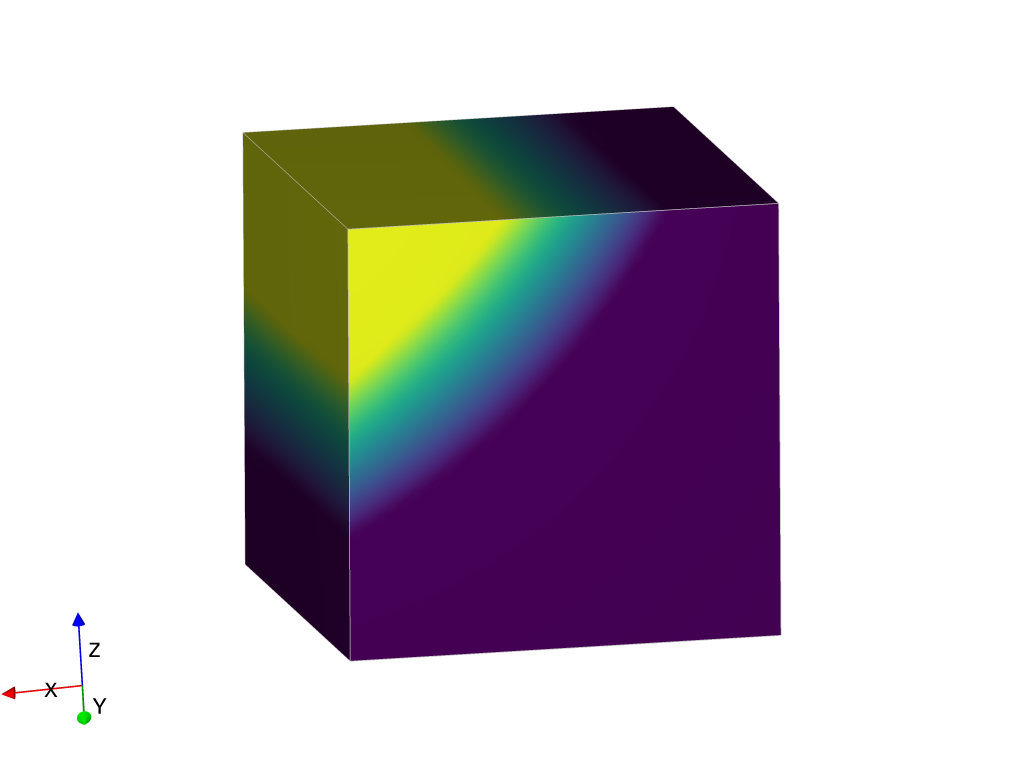

'f1_0.png'

In [14]:
viewer = LavaVuModelViewer(model)
# viewer.add_isosurface(fault['feature'],isovalue=0)
# for i in range(3):
#     viewer.add_data(fault['feature'][i])
# viewer.add_isosurface(fault['feature'][1],nslices=5)
# # viewer.add_isosurface(fault['feature'][2],nslices=5)
# viewer.add_isosurface(strati['feature'],
#                      nslices=5)
viewer.add_scalar_field(fault['feature'][0],cmap='viridis',vmin=-2,vmax=2)
# viewer.add_scalar_field(f1_displacement_feature,cmap='rainbow')
viewer.lv.rotate(rotation)
viewer.lv.display()
viewer.lv.image('f1_0.png')

### Fault frame 1

INFO:LoopStructural.visualisation.model_visualisation:Adding scalar field of fault_1 to viewer. Min: -0.003216, max: 0.003339



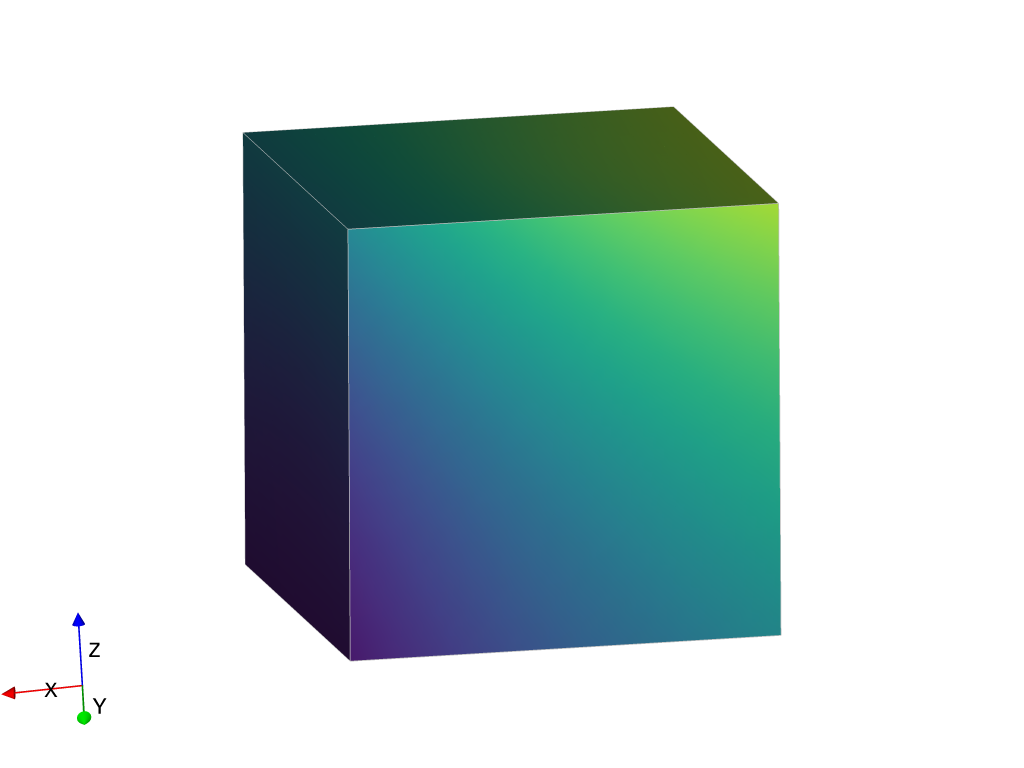

'f1_1.png'

In [15]:
viewer = LavaVuModelViewer(model)
# viewer.add_isosurface(fault['feature'],isovalue=0)
# for i in range(3):
#     viewer.add_data(fault['feature'][i])
# viewer.add_isosurface(fault['feature'][1],nslices=5)
# # viewer.add_isosurface(fault['feature'][2],nslices=5)
# viewer.add_isosurface(strati['feature'],
#                      nslices=5)
viewer.add_scalar_field(fault['feature'][1],cmap='viridis')#,vmin=-1,vmax=1)
# viewer.add_scalar_field(f1_displacement_feature,cmap='rainbow')
viewer.lv.rotate(rotation)
viewer.lv.display()
viewer.lv.image('f1_1.png')

### Fault frame 2

INFO:LoopStructural.visualisation.model_visualisation:Adding scalar field of fault_2 to viewer. Min: -0.126390, max: 1.003108



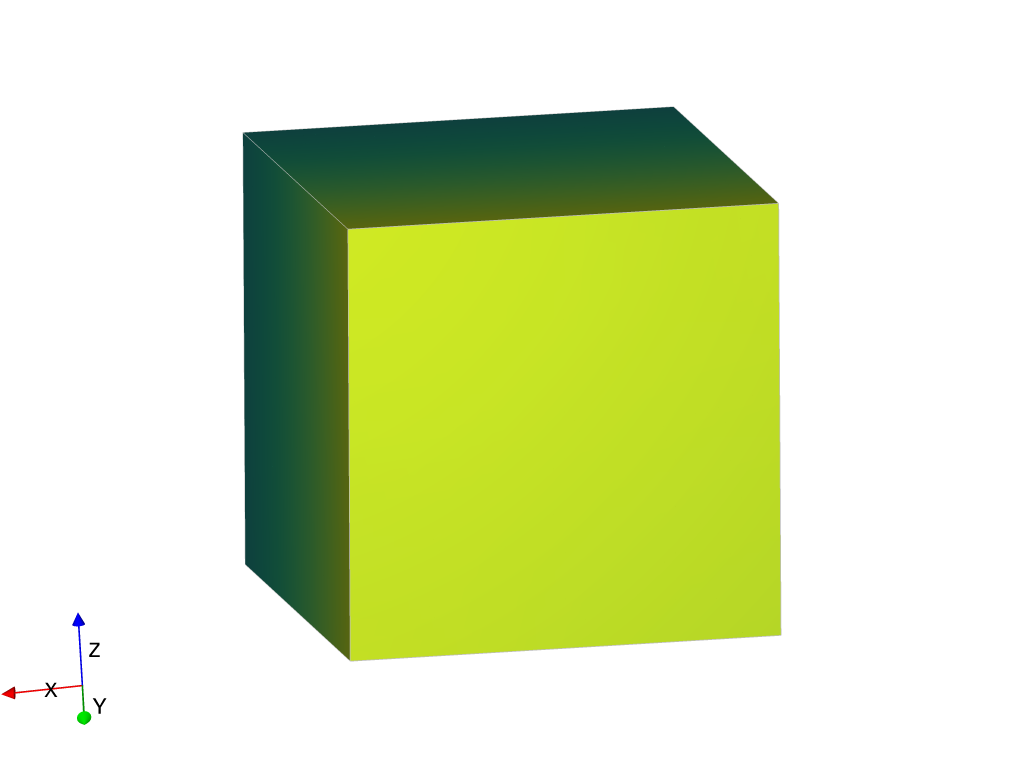

'f1_2.png'

In [16]:
viewer = LavaVuModelViewer(model)
# viewer.add_isosurface(fault['feature'],isovalue=0)
# for i in range(3):
#     viewer.add_data(fault['feature'][i])
# viewer.add_isosurface(fault['feature'][1],nslices=5)
# # viewer.add_isosurface(fault['feature'][2],nslices=5)
# viewer.add_isosurface(strati['feature'],
#                      nslices=5)
viewer.add_scalar_field(fault['feature'][2],cmap='viridis',vmin=-1,vmax=1)
# viewer.add_scalar_field(f1_displacement_feature,cmap='rainbow')
viewer.lv.rotate(rotation)
viewer.lv.display()
viewer.lv.image('f1_2.png')

In [17]:
x = np.linspace(-1,1,100)
# plt.plot(x,gxf(x))

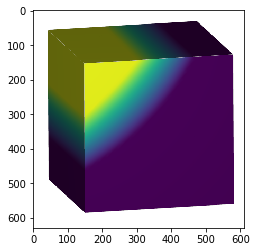

In [18]:
plt.imshow(plt.imread('f1_0.png')[75:705, 200:810,:])


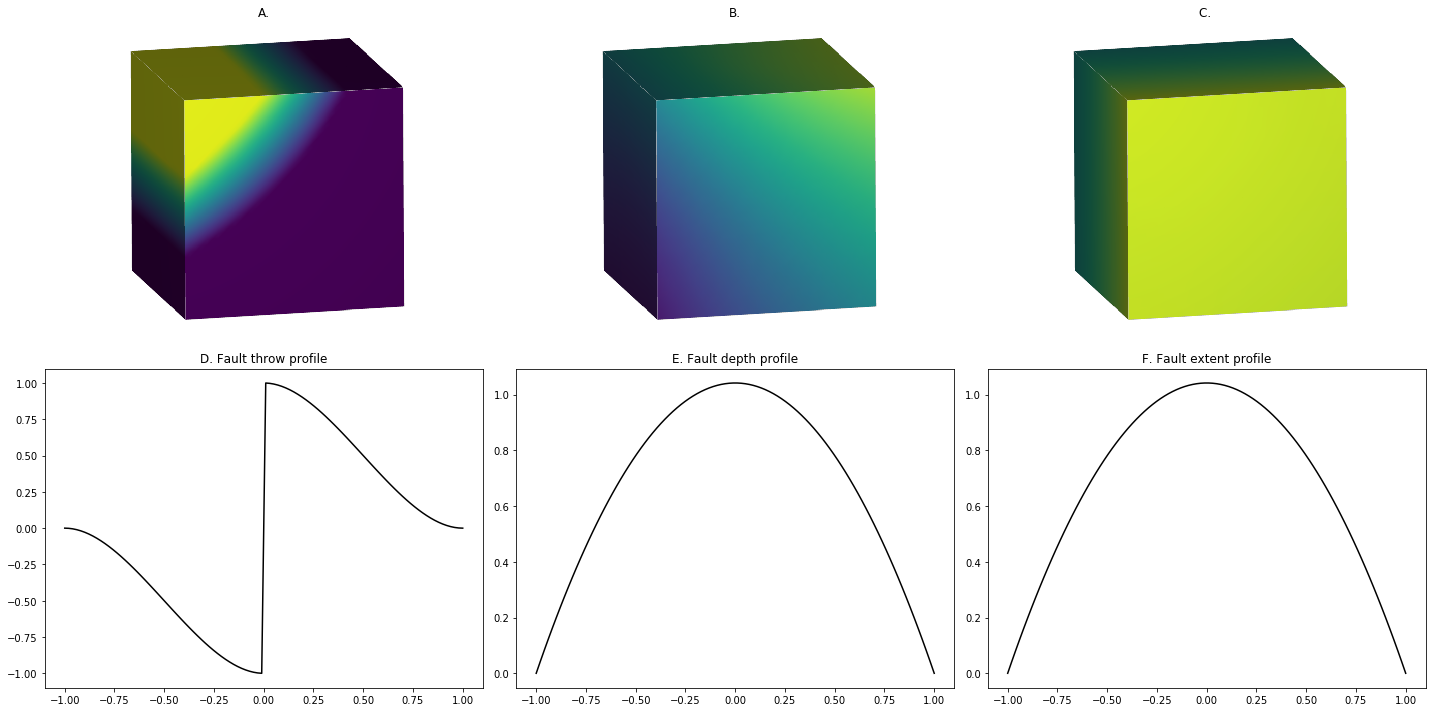

In [19]:
fig, ax = plt.subplots(2,3,figsize=(20,10))
ax[0,0].imshow(plt.imread('f1_0.png')[75:705, 200:810,:])
ax[0,0].set_title('A.')
ax[0,1].imshow(plt.imread('f1_1.png')[75:705, 200:810,:])
ax[0,1].set_title('B.')
ax[0,2].imshow(plt.imread('f1_2.png')[75:705, 200:810,:])

ax[0,2].set_title('C. ')
ax[1,0].plot(x,gxf(x),'k-')#(plt.imread('4.png')[200:565, 178:844,:])
ax[1,0].set_title('D. Fault throw profile')
ax[1,1].plot(x,gyf(x),'k-')#imshow(plt.imread('3.png')[200:565, 178:844,:])
ax[1,1].set_title('E. Fault depth profile')
ax[1,2].plot(x,gzf(x),'k-')#imshow(plt.imread('4.png')[200:565, 178:844,:])
ax[1,2].set_title('F. Fault extent profile')

for i in range(1):
    for j in range(3):
        ax[i,j].axis('off')
plt.tight_layout()

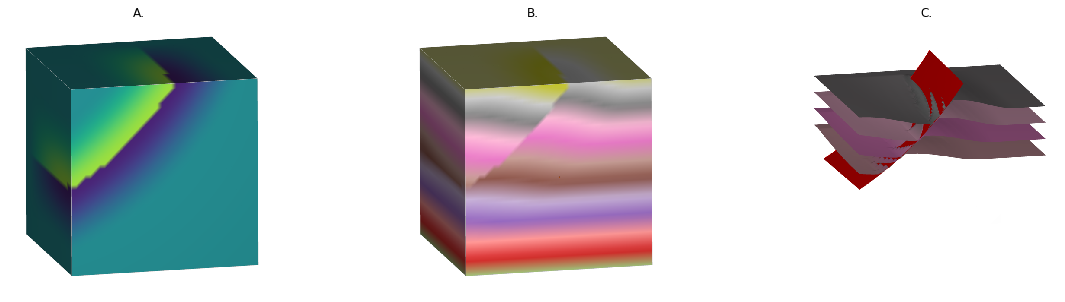

In [20]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].imshow(plt.imread(output+'/fault_displacement.png')[75:705, 200:810,:])
ax[0].set_title('A.')
ax[1].imshow(plt.imread(output+'/stratigraphy.png')[75:705, 200:810,:])
ax[1].set_title('B.')
ax[2].imshow(plt.imread(output+'/surfaces.png')[75:705, 200:810,:])
ax[2].set_title('C.')
for i in range(1):
    for j in range(3):
        ax[j].axis('off')